RSI MOMENTUM BREAKOUT STRATEGY BACKTESTING
Загрузка данных BTCUSDT с 2025-01-01 по 2025-06-08...
Загружено 1500 свечей...
Загружено 3000 свечей...
Загружено 4500 свечей...
Загружено 6000 свечей...
Загружено 7500 свечей...
Загружено 9000 свечей...
Загружено 10500 свечей...
Загружено 12000 свечей...
Загружено 13500 свечей...
Загружено 15000 свечей...
Загружено 15169 свечей...

Загружено 15169 свечей
Период данных: 2025-01-01 00:00:00 - 2025-06-08 00:00:00
Запуск бэктестирования...
2025-01-01 04:15:00: Открытие SHORT позиции по цене 93710.30
2025-01-01 09:15:00: Закрытие SHORT позиции по цене 93112.70, P&L: 0.64%
2025-01-01 10:00:00: Открытие SHORT позиции по цене 93354.80
2025-01-01 11:30:00: Закрытие SHORT позиции по цене 93581.60, P&L: -0.24%
2025-01-01 12:15:00: Открытие LONG позиции по цене 93854.70
2025-01-01 13:00:00: Закрытие LONG позиции по цене 93627.10, P&L: -0.24%
2025-01-01 15:15:00: Открытие LONG позиции по цене 94130.20
2025-01-01 17:00:00: Закрытие LONG позиции по цене 938

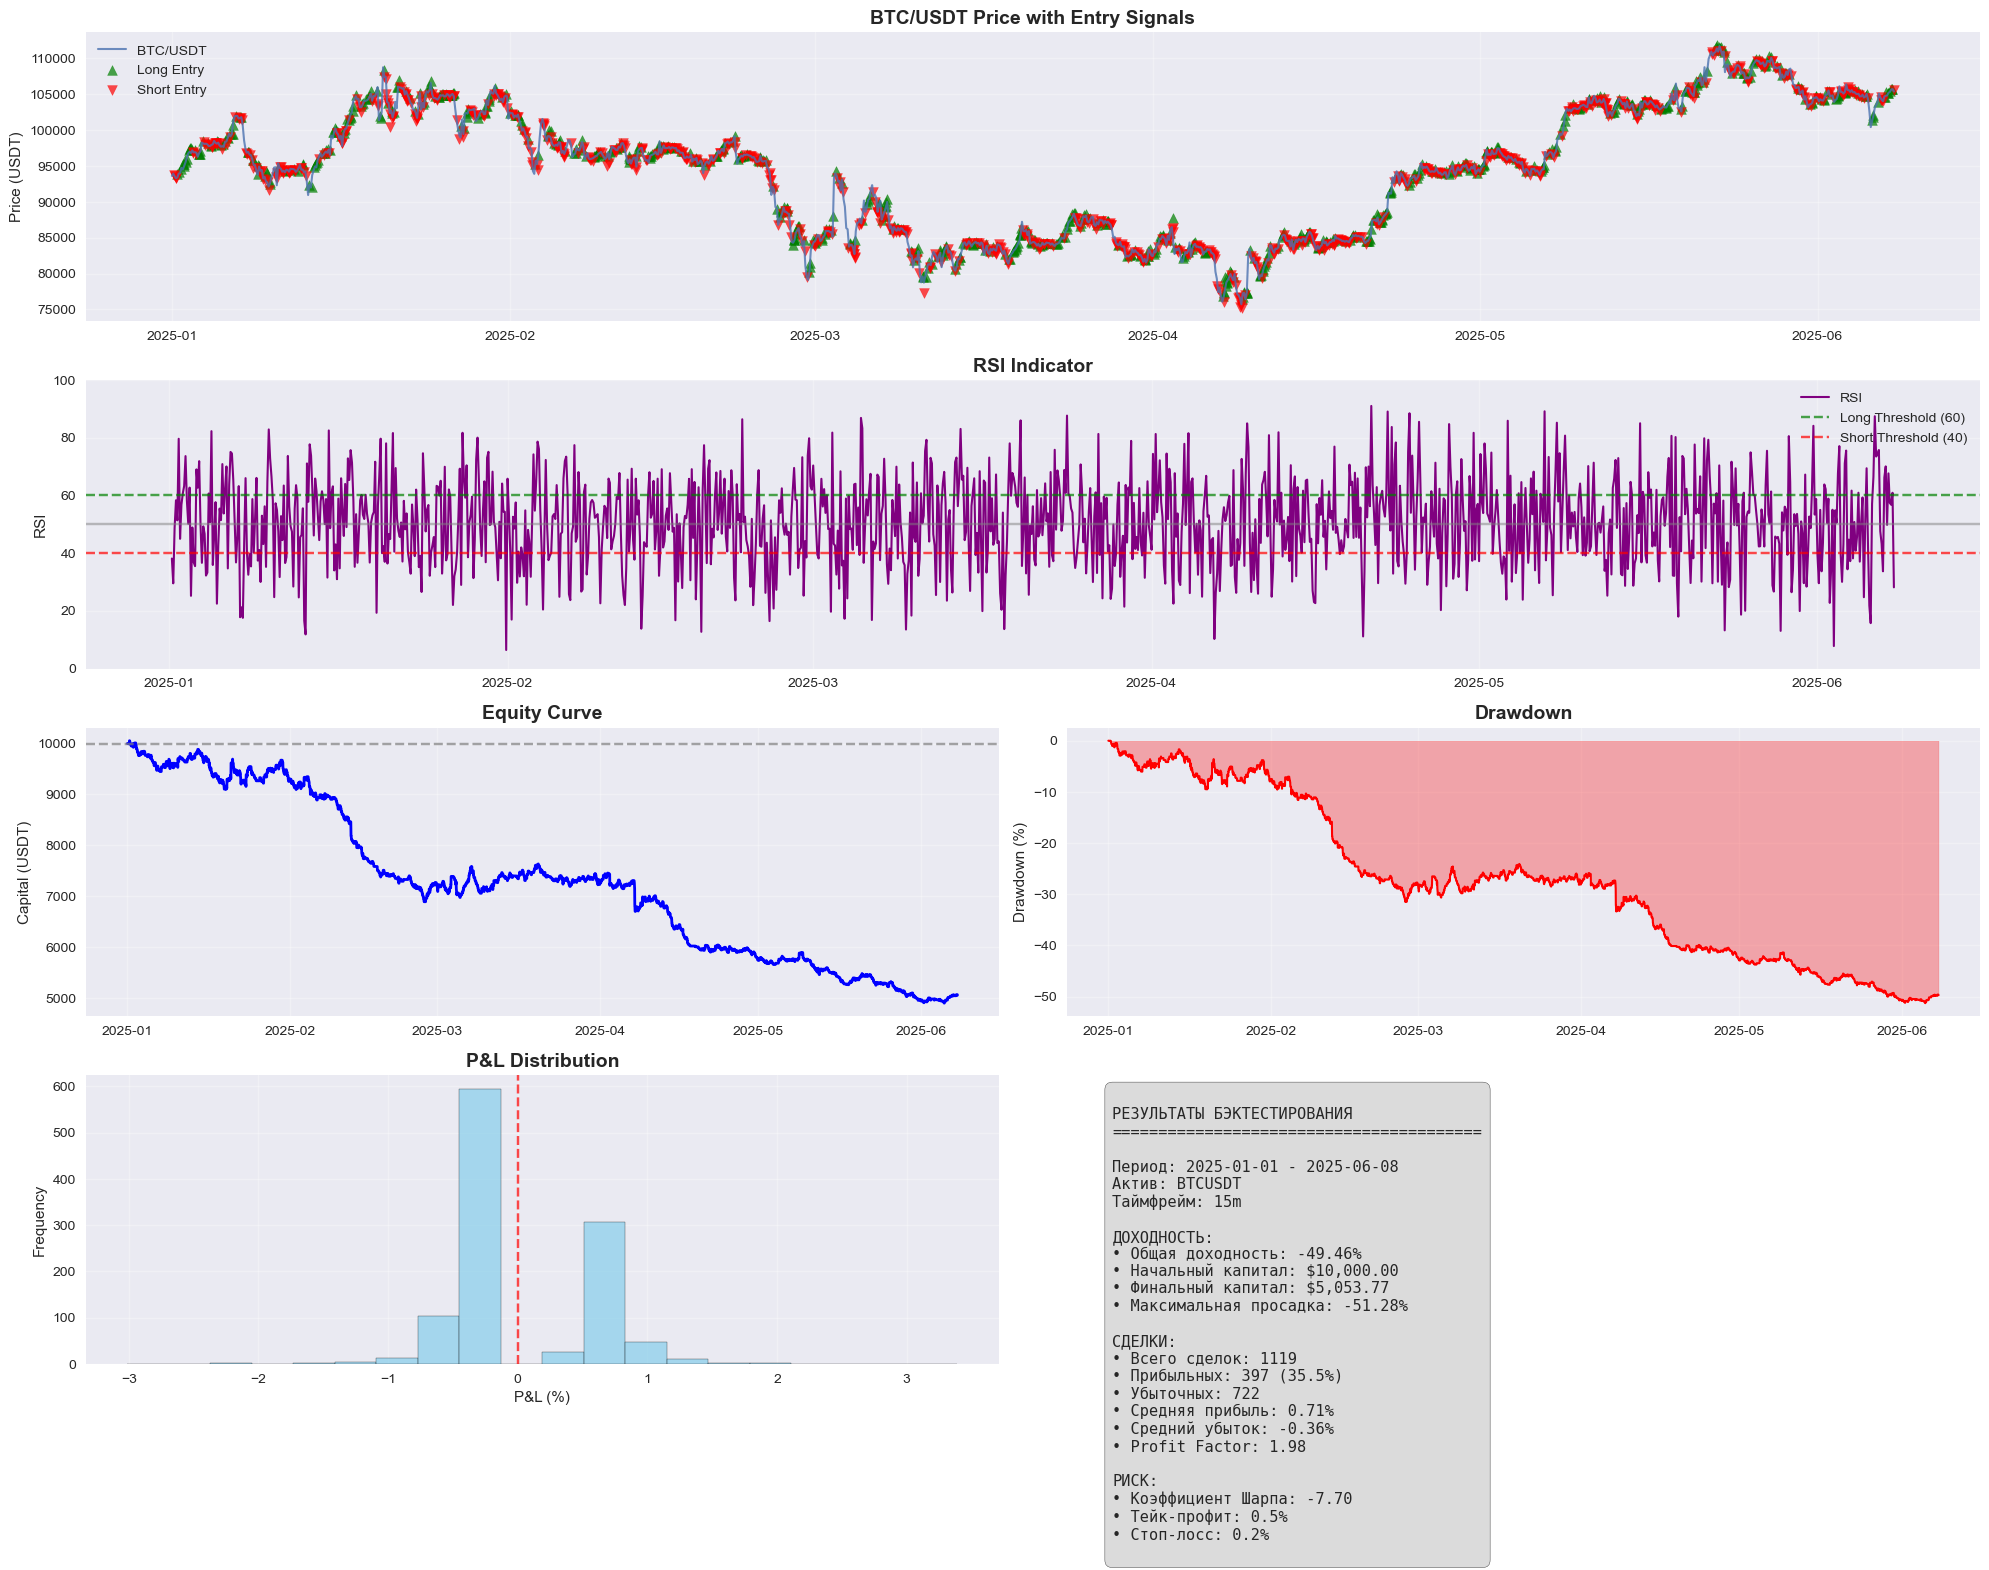


Последние 10 сделок:
--------------------------------------------------------------------------------
SHORT | Entry: $104490.50 | Exit: $103700.00 | P&L: 0.76%
LONG  | Entry: $101423.70 | Exit: $102148.10 | P&L: 0.71%
LONG  | Entry: $102148.10 | Exit: $102678.80 | P&L: 0.52%
LONG  | Entry: $103926.60 | Exit: $104507.90 | P&L: 0.56%
SHORT | Entry: $104591.40 | Exit: $104040.80 | P&L: 0.53%
SHORT | Entry: $104040.80 | Exit: $104285.80 | P&L: -0.24%
LONG  | Entry: $104686.40 | Exit: $105272.20 | P&L: 0.56%
LONG  | Entry: $105272.20 | Exit: $104894.70 | P&L: -0.36%
LONG  | Entry: $105168.80 | Exit: $105723.60 | P&L: 0.53%
LONG  | Entry: $105723.60 | Exit: $105507.50 | P&L: -0.20%


In [5]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ==============================================
# НАСТРОЙКИ СТРАТЕГИИ
# ==============================================

# Параметры подключения к API
SYMBOL = 'BTCUSDT'
INTERVAL = '15m'
BASE_URL = 'https://fapi.binance.com'

# Период бэктеста
START_DATE = '2025-01-01'
END_DATE = '2025-06-08'

# Параметры стратегии
RSI_PERIOD = 14
RSI_LONG_THRESHOLD = 60   # Вход в лонг при пробое выше 51
RSI_SHORT_THRESHOLD = 40  # Вход в шорт при пробое ниже 49

# Управление рисками
TAKE_PROFIT_PCT = 0.005   # 1%
STOP_LOSS_PCT = 0.002     # 0.2%

# Параметры торговли
INITIAL_CAPITAL = 10000   # Начальный капитал в USDT
POSITION_SIZE_PCT = 1.0   # Размер позиции (100% капитала)
COMMISSION_PCT = 0.0004   # Комиссия 0.04%

# Параметры графиков
plt.style.use('seaborn-v0_8')
FIGURE_SIZE = (15, 10)

# ==============================================
# ЗАГРУЗКА ДАННЫХ
# ==============================================

def get_binance_klines(symbol, interval, start_date, end_date):
    """Получение исторических данных с Binance Futures API"""
    
    # Конвертация дат в timestamp
    start_ts = int(pd.to_datetime(start_date).timestamp() * 1000)
    end_ts = int(pd.to_datetime(end_date).timestamp() * 1000)
    
    all_klines = []
    current_start = start_ts
    
    print(f"Загрузка данных {symbol} с {start_date} по {end_date}...")
    
    while current_start < end_ts:
        url = f"{BASE_URL}/fapi/v1/klines"
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ts,
            'limit': 1500
        }
        
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            klines = response.json()
            
            if not klines:
                break
                
            all_klines.extend(klines)
            current_start = klines[-1][6] + 1  # Следующий timestamp
            
            print(f"Загружено {len(all_klines)} свечей...")
            
        except requests.exceptions.RequestException as e:
            print(f"Ошибка при загрузке данных: {e}")
            break
    
    # Создание DataFrame
    df = pd.DataFrame(all_klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    
    # Конвертация типов данных
    numeric_cols = ['open', 'high', 'low', 'close', 'volume']
    df[numeric_cols] = df[numeric_cols].astype(float)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    
    return df[['open', 'high', 'low', 'close', 'volume']]

# ==============================================
# ТЕХНИЧЕСКИЕ ИНДИКАТОРЫ
# ==============================================

def calculate_rsi(prices, period=14):
    """Расчет RSI"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ==============================================
# ОСНОВНАЯ СТРАТЕГИЯ
# ==============================================

class RSIMomentumStrategy:
    def __init__(self, data, initial_capital=INITIAL_CAPITAL):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.position = 0  # 0 - нет позиции, 1 - лонг, -1 - шорт
        self.entry_price = 0
        self.trades = []
        self.equity_curve = []
        
    def calculate_indicators(self):
        """Расчет технических индикаторов"""
        self.data['rsi'] = calculate_rsi(self.data['close'], RSI_PERIOD)
        
    def generate_signals(self):
        """Генерация торговых сигналов"""
        self.data['signal'] = 0
        
        # Сигналы на покупку (лонг)
        long_condition = (
            (self.data['rsi'] > RSI_LONG_THRESHOLD) & 
            (self.data['rsi'].shift(1) <= RSI_LONG_THRESHOLD)
        )
        
        # Сигналы на продажу (шорт)
        short_condition = (
            (self.data['rsi'] < RSI_SHORT_THRESHOLD) & 
            (self.data['rsi'].shift(1) >= RSI_SHORT_THRESHOLD)
        )
        
        self.data.loc[long_condition, 'signal'] = 1
        self.data.loc[short_condition, 'signal'] = -1
        
    def run_backtest(self):
        """Запуск бэктестирования"""
        print("Запуск бэктестирования...")
        
        self.calculate_indicators()
        self.generate_signals()
        
        for i, (timestamp, row) in enumerate(self.data.iterrows()):
            current_price = row['close']
            signal = row['signal']
            
            # Проверка выхода из позиции по стоп-лоссу или тейк-профиту
            if self.position != 0:
                if self.position == 1:  # Лонг позиция
                    profit_pct = (current_price - self.entry_price) / self.entry_price
                    if profit_pct >= TAKE_PROFIT_PCT or profit_pct <= -STOP_LOSS_PCT:
                        self.close_position(timestamp, current_price, 'TP/SL')
                
                elif self.position == -1:  # Шорт позиция
                    profit_pct = (self.entry_price - current_price) / self.entry_price
                    if profit_pct >= TAKE_PROFIT_PCT or profit_pct <= -STOP_LOSS_PCT:
                        self.close_position(timestamp, current_price, 'TP/SL')
            
            # Новые сигналы
            if signal != 0 and self.position == 0:
                if signal == 1:  # Лонг сигнал
                    self.open_position(timestamp, current_price, 1)
                elif signal == -1:  # Шорт сигнал
                    self.open_position(timestamp, current_price, -1)
            
            # Сохранение кривой капитала
            self.equity_curve.append({
                'timestamp': timestamp,
                'capital': self.capital,
                'position': self.position,
                'price': current_price
            })
    
    def open_position(self, timestamp, price, direction):
        """Открытие позиции"""
        self.position = direction
        self.entry_price = price
        
        # Расчет размера позиции с учетом комиссии
        position_value = self.capital * POSITION_SIZE_PCT
        commission = position_value * COMMISSION_PCT
        self.capital -= commission
        
        trade_type = 'LONG' if direction == 1 else 'SHORT'
        print(f"{timestamp}: Открытие {trade_type} позиции по цене {price:.2f}")
    
    def close_position(self, timestamp, price, reason):
        """Закрытие позиции"""
        if self.position == 0:
            return
        
        # Расчет P&L
        if self.position == 1:  # Закрытие лонг позиции
            pnl_pct = (price - self.entry_price) / self.entry_price
        else:  # Закрытие шорт позиции
            pnl_pct = (self.entry_price - price) / self.entry_price
        
        # Обновление капитала
        position_value = self.capital * POSITION_SIZE_PCT / (1 - COMMISSION_PCT)
        pnl = position_value * pnl_pct
        commission = position_value * COMMISSION_PCT
        
        self.capital += pnl - commission
        
        # Запись сделки
        trade = {
            'entry_time': None,  # Найдем позже
            'exit_time': timestamp,
            'entry_price': self.entry_price,
            'exit_price': price,
            'direction': 'LONG' if self.position == 1 else 'SHORT',
            'pnl_pct': pnl_pct * 100,
            'pnl_abs': pnl,
            'reason': reason
        }
        
        self.trades.append(trade)
        
        trade_type = 'LONG' if self.position == 1 else 'SHORT'
        print(f"{timestamp}: Закрытие {trade_type} позиции по цене {price:.2f}, P&L: {pnl_pct*100:.2f}%")
        
        self.position = 0
        self.entry_price = 0

# ==============================================
# АНАЛИЗ РЕЗУЛЬТАТОВ
# ==============================================

def calculate_metrics(strategy):
    """Расчет метрик производительности"""
    equity_df = pd.DataFrame(strategy.equity_curve)
    
    if len(strategy.trades) == 0:
        return {}
    
    trades_df = pd.DataFrame(strategy.trades)
    
    # Основные метрики
    total_return = (strategy.capital - strategy.initial_capital) / strategy.initial_capital * 100
    
    # Расчет максимальной просадки
    equity_df['peak'] = equity_df['capital'].cummax()
    equity_df['drawdown'] = (equity_df['capital'] - equity_df['peak']) / equity_df['peak'] * 100
    max_drawdown = equity_df['drawdown'].min()
    
    # Метрики сделок
    winning_trades = trades_df[trades_df['pnl_pct'] > 0]
    losing_trades = trades_df[trades_df['pnl_pct'] < 0]
    
    win_rate = len(winning_trades) / len(trades_df) * 100
    avg_win = winning_trades['pnl_pct'].mean() if len(winning_trades) > 0 else 0
    avg_loss = losing_trades['pnl_pct'].mean() if len(losing_trades) > 0 else 0
    
    # Коэффициент Шарпа (упрощенный)
    returns = equity_df['capital'].pct_change().dropna()
    sharpe = returns.mean() / returns.std() * np.sqrt(252 * 288) if returns.std() > 0 else 0  # 288 = 5-min periods per day
    
    metrics = {
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'total_trades': len(trades_df),
        'winning_trades': len(winning_trades),
        'losing_trades': len(losing_trades),
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': abs(avg_win / avg_loss) if avg_loss != 0 else 0,
        'sharpe_ratio': sharpe,
        'final_capital': strategy.capital
    }
    
    return metrics, equity_df, trades_df

def create_visualizations(strategy, metrics, equity_df, trades_df):
    """Создание графиков"""
    fig = plt.figure(figsize=(20, 16))
    
    # График 1: Цена и сигналы
    ax1 = plt.subplot(4, 2, (1, 2))
    
    # Основной график цены
    price_data = strategy.data.iloc[::12]  # Каждая 12-я точка для читаемости
    ax1.plot(price_data.index, price_data['close'], label='BTC/USDT', linewidth=1.5, alpha=0.8)
    
    # Сигналы входа
    long_signals = strategy.data[strategy.data['signal'] == 1]
    short_signals = strategy.data[strategy.data['signal'] == -1]
    
    ax1.scatter(long_signals.index, long_signals['close'], 
               color='green', marker='^', s=50, label='Long Entry', alpha=0.7)
    ax1.scatter(short_signals.index, short_signals['close'], 
               color='red', marker='v', s=50, label='Short Entry', alpha=0.7)
    
    ax1.set_title('BTC/USDT Price with Entry Signals', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price (USDT)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: RSI
    ax2 = plt.subplot(4, 2, (3, 4))
    rsi_data = strategy.data.iloc[::12]
    ax2.plot(rsi_data.index, rsi_data['rsi'], label='RSI', color='purple', linewidth=1.5)
    ax2.axhline(y=RSI_LONG_THRESHOLD, color='green', linestyle='--', alpha=0.7, label=f'Long Threshold ({RSI_LONG_THRESHOLD})')
    ax2.axhline(y=RSI_SHORT_THRESHOLD, color='red', linestyle='--', alpha=0.7, label=f'Short Threshold ({RSI_SHORT_THRESHOLD})')
    ax2.axhline(y=50, color='gray', linestyle='-', alpha=0.5)
    
    ax2.set_title('RSI Indicator', fontsize=14, fontweight='bold')
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График 3: Кривая капитала
    ax3 = plt.subplot(4, 2, 5)
    ax3.plot(equity_df['timestamp'], equity_df['capital'], linewidth=2, color='blue')
    ax3.axhline(y=strategy.initial_capital, color='gray', linestyle='--', alpha=0.7)
    ax3.set_title('Equity Curve', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Capital (USDT)')
    ax3.grid(True, alpha=0.3)
    
    # График 4: Просадка
    ax4 = plt.subplot(4, 2, 6)
    ax4.fill_between(equity_df['timestamp'], equity_df['drawdown'], 0, 
                     color='red', alpha=0.3, label='Drawdown')
    ax4.plot(equity_df['timestamp'], equity_df['drawdown'], color='red', linewidth=1.5)
    ax4.set_title('Drawdown', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Drawdown (%)')
    ax4.grid(True, alpha=0.3)
    
    # График 5: Распределение P&L сделок
    ax5 = plt.subplot(4, 2, 7)
    if len(trades_df) > 0:
        ax5.hist(trades_df['pnl_pct'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax5.axvline(x=0, color='red', linestyle='--', alpha=0.7)
        ax5.set_title('P&L Distribution', fontsize=14, fontweight='bold')
        ax5.set_xlabel('P&L (%)')
        ax5.set_ylabel('Frequency')
        ax5.grid(True, alpha=0.3)
    
    # График 6: Метрики (текст)
    ax6 = plt.subplot(4, 2, 8)
    ax6.axis('off')
    
    metrics_text = f"""
РЕЗУЛЬТАТЫ БЭКТЕСТИРОВАНИЯ
{'='*40}

Период: {START_DATE} - {END_DATE}
Актив: {SYMBOL}
Таймфрейм: {INTERVAL}

ДОХОДНОСТЬ:
• Общая доходность: {metrics['total_return']:.2f}%
• Начальный капитал: ${strategy.initial_capital:,.2f}
• Финальный капитал: ${metrics['final_capital']:,.2f}
• Максимальная просадка: {metrics['max_drawdown']:.2f}%

СДЕЛКИ:
• Всего сделок: {metrics['total_trades']}
• Прибыльных: {metrics['winning_trades']} ({metrics['win_rate']:.1f}%)
• Убыточных: {metrics['losing_trades']}
• Средняя прибыль: {metrics['avg_win']:.2f}%
• Средний убыток: {metrics['avg_loss']:.2f}%
• Profit Factor: {metrics['profit_factor']:.2f}

РИСК:
• Коэффициент Шарпа: {metrics['sharpe_ratio']:.2f}
• Тейк-профит: {TAKE_PROFIT_PCT*100:.1f}%
• Стоп-лосс: {STOP_LOSS_PCT*100:.1f}%
    """
    
    ax6.text(0.05, 0.95, metrics_text, transform=ax6.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# ==============================================
# ОСНОВНОЙ КОД ВЫПОЛНЕНИЯ
# ==============================================

def main():
    print("="*60)
    print("RSI MOMENTUM BREAKOUT STRATEGY BACKTESTING")
    print("="*60)
    
    try:
        # Загрузка данных
        data = get_binance_klines(SYMBOL, INTERVAL, START_DATE, END_DATE)
        print(f"\nЗагружено {len(data)} свечей")
        print(f"Период данных: {data.index[0]} - {data.index[-1]}")
        
        # Запуск стратегии
        strategy = RSIMomentumStrategy(data, INITIAL_CAPITAL)
        strategy.run_backtest()
        
        # Анализ результатов
        if len(strategy.trades) > 0:
            metrics, equity_df, trades_df = calculate_metrics(strategy)
            
            # Вывод результатов
            print("\n" + "="*60)
            print("РЕЗУЛЬТАТЫ БЭКТЕСТИРОВАНИЯ")
            print("="*60)
            
            print(f"\nОбщая доходность: {metrics['total_return']:.2f}%")
            print(f"Максимальная просадка: {metrics['max_drawdown']:.2f}%")
            print(f"Всего сделок: {metrics['total_trades']}")
            print(f"Винрейт: {metrics['win_rate']:.1f}%")
            print(f"Profit Factor: {metrics['profit_factor']:.2f}")
            print(f"Коэффициент Шарпа: {metrics['sharpe_ratio']:.2f}")
            print(f"Финальный капитал: ${metrics['final_capital']:,.2f}")
            
            # Создание графиков
            create_visualizations(strategy, metrics, equity_df, trades_df)
            
            # Детальная таблица сделок (первые 10)
            print("\nПоследние 10 сделок:")
            print("-" * 80)
            recent_trades = trades_df.tail(10)
            for _, trade in recent_trades.iterrows():
                print(f"{trade['direction']:<5} | Entry: ${trade['entry_price']:.2f} | "
                      f"Exit: ${trade['exit_price']:.2f} | P&L: {trade['pnl_pct']:.2f}%")
        
        else:
            print("\nСделок не было совершено. Проверьте параметры стратегии.")
            
    except Exception as e:
        print(f"Ошибка выполнения: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()